# Credit Risk Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.library import IntegerComparator
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation

### 1. Problem Definition

In [2]:
n_z = 2
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**n_z)
p_zeros = [0.15, 0.25]
rhos = [0.1, 0.05]
lgd = [1, 2]
K = len(p_zeros)
alpha = 0.05

### 2. Uncertainty Model

In [3]:
from qiskit.finance.applications import GaussianConditionalIndependenceModel as GCI
u = GCI(n_z, z_max, p_zeros, rhos)

C:\Users\arkou\anaconda3\lib\site-packages\qiskit\finance\__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')
C:\Users\arkou\anaconda3\lib\site-packages\qiskit\finance\applications\gaussian_conditional_independence_model.py:83: DeprecationWarning: `NormalDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.NormalDistribution.
  normal_distribution = NormalDistribution(n_normal, 0, 1,


In [4]:
u.draw()

┌───────┐┌─────────┐┌─────────┐
q_0: ┤0      ├┤0        ├┤0        ├
     │  P(X) ││         ││         │
q_1: ┤1      ├┤1 LinRot ├┤1        ├
     └───────┘│         ││  LinRot │
q_2: ─────────┤2        ├┤         ├
              └─────────┘│         │
q_3: ────────────────────┤2        ├
                         └─────────┘

In [5]:
job = execute(u, backend=Aer.get_backend('statevector_simulator'))

In [6]:
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
for i, a in enumerate(job.result().get_statevector()):
    
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2

    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var+1):], losses[(i_var+1):])/sum(pdf[(i_var+1):])

In [7]:
print('Expected Loss E[L]:                %.4f' % expected_loss)
print('Value at Risk VaR[L]:              %.4f' % exact_var)
print('P[L <= VaR[L]]:                    %.4f' % cdf[exact_var])
print('Conditional Value at Risk CVaR[L]: %.4f' % exact_cvar)

Expected Loss E[L]:                0.6409
Value at Risk VaR[L]:              2.0000
P[L <= VaR[L]]:                    0.9591
Conditional Value at Risk CVaR[L]: 3.0000


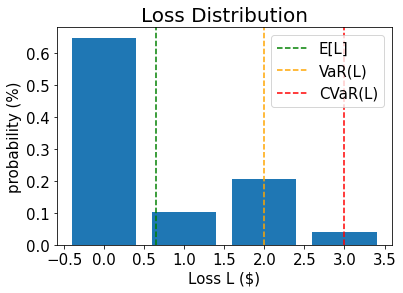

In [8]:
plt.bar(losses, pdf)
plt.axvline(expected_loss, color='green', linestyle='--', label='E[L]')
plt.axvline(exact_var, color='orange', linestyle='--', label='VaR(L)')
plt.axvline(exact_cvar, color='red', linestyle='--', label='CVaR(L)')
plt.legend(fontsize=15)
plt.xlabel('Loss L ($)', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Loss Distribution', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

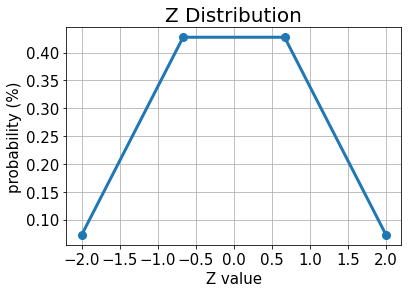

In [9]:
plt.plot(z_values, p_z, 'o-', linewidth=3, markersize=8)
plt.grid()
plt.xlabel('Z value', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Z Distribution', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

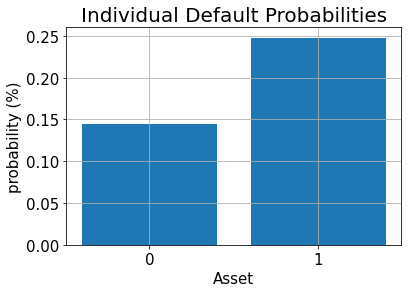

In [10]:
plt.bar(range(K), p_default)
plt.xlabel('Asset', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Individual Default Probabilities', size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

### 3. Expected Loss

In [11]:
from qiskit.circuit.library import WeightedAdder
agg = WeightedAdder(n_z + K, [0]*n_z + lgd)

In [12]:
from qiskit.circuit.library import LinearAmplitudeFunction

breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes, 
    offset=offsets, 

    domain=(0, 2**agg.num_sum_qubits-1),  
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints
)

In [13]:
qr_state = QuantumRegister(u.num_qubits, 'state')
qr_sum = QuantumRegister(agg.num_sum_qubits, 'sum')
qr_carry = QuantumRegister(agg.num_carry_qubits, 'carry')
qr_obj = QuantumRegister(1, 'objective')

state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name='A')

state_preparation.append(u.to_gate(), qr_state)

state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

state_preparation.draw()

┌───────┐┌────────┐      ┌───────────┐
    state_0: ┤0      ├┤0       ├──────┤0          ├
             │       ││        │      │           │
    state_1: ┤1      ├┤1       ├──────┤1          ├
             │  P(X) ││        │      │           │
    state_2: ┤2      ├┤2       ├──────┤2          ├
             │       ││        │      │           │
    state_3: ┤3      ├┤3       ├──────┤3          ├
             └───────┘│  adder │┌────┐│  adder_dg │
objective_0: ─────────┤        ├┤2   ├┤           ├
                      │        ││    ││           │
      sum_0: ─────────┤4       ├┤0 F ├┤4          ├
                      │        ││    ││           │
      sum_1: ─────────┤5       ├┤1   ├┤5          ├
                      │        │└────┘│           │
    carry_0: ─────────┤6       ├──────┤6          ├
                      └────────┘      └───────────┘

In [14]:
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

In [15]:
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1):]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == '1':
        value += am**2

print('Exact Expected Loss:   %.4f' % expected_loss) 
print('Exact Operator Value:  %.4f' % value)
print('Mapped Operator value: %.4f' % objective.post_processing(value))

Exact Expected Loss:   0.6409
Exact Operator Value:  0.3906
Mapped Operator value: 0.6640


In [16]:
epsilon = 0.01
alpha = 0.05

ae = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                  epsilon=epsilon, alpha=alpha,
                                  objective_qubits=[len(qr_state)],
                                  post_processing=objective.post_processing)
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

conf_int = np.array(result['confidence_interval'])
print('Exact value:    \t%.4f' % expected_loss)
print('Estimated value:\t%.4f' % result['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

C:\Users\arkou\anaconda3\lib\site-packages\qiskit\aqua\algorithms\amplitude_estimators\ae_algorithm.py:91: DeprecationWarning: The package qiskit.aqua.algorithms.amplitude_estimators is deprecated. It was moved/refactored to qiskit.algorithms.amplitude_estimators (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.algorithms.amplitude_estimators',
C:\Users\arkou\anaconda3\lib\site-packages\qiskit\aqua\quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',


Exact value:    	0.6409
Estimated value:	0.6863
Confidence interval: 	[0.6175, 0.7552]


### 4. Cumulative Distribution Function

In [17]:
x_eval = 2

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
comparator.draw()

state_0: ──■──────────────■──
             │              │  
  state_1: ──┼────■─────────┼──
             │  ┌─┴─┐┌───┐  │  
compare_0: ──┼──┤ X ├┤ X ├──┼──
           ┌─┴─┐└─┬─┘└───┘┌─┴─┐
     a0_0: ┤ X ├──■───────┤ X ├
           └───┘          └───┘

In [18]:
def get_cdf_circuit(x_eval):

    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_sum = QuantumRegister(agg.num_sum_qubits, 'sum')
    qr_carry = QuantumRegister(agg.num_carry_qubits, 'carry')
    qr_obj = QuantumRegister(1, 'objective')
    qr_compare = QuantumRegister(1, 'compare')

    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name='A')

    state_preparation.append(u, qr_state)

    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])

    state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])
    
    return state_preparation
    
state_preparation = get_cdf_circuit(x_eval)

In [19]:
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

In [20]:
state_preparation.draw()

┌───────┐┌────────┐        ┌───────────┐
    state_0: ┤0      ├┤0       ├────────┤0          ├
             │       ││        │        │           │
    state_1: ┤1      ├┤1       ├────────┤1          ├
             │  P(X) ││        │        │           │
    state_2: ┤2      ├┤2       ├────────┤2          ├
             │       ││        │        │           │
    state_3: ┤3      ├┤3       ├────────┤3          ├
             └───────┘│  adder │┌──────┐│  adder_dg │
objective_0: ─────────┤        ├┤2     ├┤           ├
                      │        ││      ││           │
      sum_0: ─────────┤4       ├┤0     ├┤4          ├
                      │        ││  cmp ││           │
      sum_1: ─────────┤5       ├┤1     ├┤5          ├
                      │        ││      ││           │
    carry_0: ─────────┤6       ├┤3     ├┤6          ├
                      └────────┘└──────┘└───────────┘

In [21]:
var_prob = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1):]
    prob = np.abs(a)**2
    if prob > 1e-6 and b[0] == '1':
        var_prob += prob
print('Operator CDF(%s)' % x_eval + ' = %.4f' % var_prob)
print('Exact    CDF(%s)' % x_eval + ' = %.4f' % cdf[x_eval])

Operator CDF(2) = 0.9591
Exact    CDF(2) = 0.9591


In [22]:
epsilon = 0.01
alpha = 0.05

ae_cdf = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                      epsilon=epsilon, alpha=alpha,
                                      objective_qubits=[len(qr_state)])
result_cdf = ae_cdf.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

conf_int = np.array(result_cdf['confidence_interval'])
print('Exact value:    \t%.4f' % cdf[x_eval])
print('Estimated value:\t%.4f' % result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Exact value:    	0.9591
Estimated value:	0.9591
Confidence interval: 	[0.9583, 0.9600]


### 5. Value at Risk

In [23]:
def run_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05, simulator='qasm_simulator'):

    state_preparation = get_cdf_circuit(x_eval)
    ae_var = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                          epsilon=epsilon, alpha=alpha,
                                          objective_qubits=[len(qr_state)]) 
    result_var = ae_var.run(quantum_instance=Aer.get_backend(simulator), shots=100)
    
    return result_var['estimation']

In [24]:
def bisection_search(objective, target_value, low_level, high_level, low_value=None, high_value=None):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    print('--------------------------------------------------------------------')
    print('start bisection search for target value %.3f' % target_value)
    print('--------------------------------------------------------------------')
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1    
        
    if low_value > target_value:
        return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'returned low value'}
    elif low_value == target_value:
        return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'success'}

    if high_value < target_value:
        return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'returned low value'}
    elif high_value == target_value:
        return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}

    print('low_level    low_value    level    value    high_level    high_value')
    print('--------------------------------------------------------------------')
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print('%2d           %.3f        %2d       %.3f    %2d            %.3f' \
              % (low_level, low_value, level, value, high_level, high_value))

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    print('--------------------------------------------------------------------')
    print('finished bisection search')
    print('--------------------------------------------------------------------')
    return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}

In [25]:
objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(objective, 1-alpha, min(losses)-1, max(losses), low_value=0, high_value=1)
var = bisection_result['level']

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         1       0.746     3            1.000
 1           0.746         2       0.958     3            1.000
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [26]:
print('Estimated Value at Risk: %2d' % var)
print('Exact Value at Risk:     %2d' % exact_var)
print('Estimated Probability:    %.3f' % bisection_result['value'])
print('Exact Probability:        %.3f' % cdf[exact_var])

Estimated Value at Risk:  2
Exact Value at Risk:      2
Estimated Probability:    0.958
Exact Probability:        0.959


### 6. Conditional Value at Risk

In [27]:
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = 3 - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slopes, 
    offsets, 
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints
)

cvar_objective.draw()

┌─────────┐┌──────┐┌─────────┐┌─────────┐
q190_0: ┤0        ├┤0     ├┤0        ├┤0        ├
        │         ││      ││         ││         │
q190_1: ┤1 LinRot ├┤1     ├┤1 LinRot ├┤1        ├
        │         ││      ││         ││         │
q191_0: ┤2        ├┤  cmp ├┤2        ├┤  cmp_dg ├
        └─────────┘│      │└────┬────┘│         │
  a4_0: ───────────┤2     ├─────■─────┤2        ├
                   │      │           │         │
  a4_1: ───────────┤3     ├───────────┤3        ├
                   └──────┘           └─────────┘

In [28]:
qr_state = QuantumRegister(u.num_qubits, 'state')
qr_sum = QuantumRegister(agg.num_sum_qubits, 'sum')
qr_carry = QuantumRegister(agg.num_carry_qubits, 'carry')
qr_obj = QuantumRegister(1, 'objective')
qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), 'work')

state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_work, name='A')

state_preparation.append(u, qr_state)

state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])

state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

In [29]:
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

In [30]:
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1):]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == '1':
        value += am**2

value = cvar_objective.post_processing(value)
d = (1.0 - bisection_result['value'])
v = value / d if d != 0 else 0
normalized_value = v + var
print('Estimated CVaR: %.4f' % normalized_value)
print('Exact CVaR:     %.4f' % exact_cvar)

Estimated CVaR: 3.2640
Exact CVaR:     3.0000


In [31]:
epsilon = 0.01
alpha = 0.05

ae_cvar = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                       epsilon=epsilon, alpha=alpha, 
                                       objective_qubits=[len(qr_state)],
                                       post_processing=cvar_objective.post_processing)
result_cvar = ae_cvar.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [32]:
d = (1.0 - bisection_result['value'])
v = result_cvar['estimation'] / d if d != 0 else 0
print('Exact CVaR:    \t%.4f' % exact_cvar)
print('Estimated CVaR:\t%.4f' % (v + var))

Exact CVaR:    	3.0000
Estimated CVaR:	3.3641


In [33]:
import qiskit.tools.jupyter
%qiskit_copyright

#### Please note that this code has been altered from the original tutorial.